In [2]:
!pip3 install datasets
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 50.3 MB/s eta 0:00:00
  Att

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
import torch
from datasets import Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd "/content/drive/MyDrive/epfl_ml_project/BP_LM"

/content/drive/MyDrive/epfl_ml_project/BP_LM


In [6]:
# Import helper methods
from data_preprocessing import *

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Loading and prepping our dataset

In [8]:
# Load our dataset
file_path = '../dataset/Data_GRCh38_canonical_transcript_intron_bp_database_Peng_20241113.txt'
df = pd.read_csv(file_path, delimiter = "\t")

In [13]:
def one_row_BP_pos(sample):

    BP_pos = sample['BP_POS_WITHIN_STRAND'] if 'BP_POS_WITHIN_STRAND' in sample else sample['BP_POS'] - sample['START']
    BP_nucleotide = sample['IVS_SEQ'][BP_pos]
    print(sample)
    first_part = sample['IVS_SEQ'][(BP_pos - 15):BP_pos]
    second_part = sample['IVS_SEQ'][(BP_pos+1):(BP_pos + 16)]
    print(f'{first_part} {BP_nucleotide} {second_part}')
    print()

In [14]:
# Load our dataset
file_path = '../dataset/Data_GRCh38_canonical_transcript_intron_bp_database_Peng_20241113.txt'
df = pd.read_csv(file_path, delimiter = "\t")

# TEST THAT THE PREPROCESSING WORKED
# A postive strand and and a negative strand before preprocessing
print("BEFORE PROCESSING:\n")
one_row_BP_pos(df.iloc[1])
one_row_BP_pos(df.iloc[100000])

print()
preprocess_data(df)
print("AFTER PROCESSING:\n")
one_row_BP_pos(df.iloc[1])
one_row_BP_pos(df.iloc[100000])

BEFORE PROCESSING:

CHR                                                         chr1
START                                                     926014
END                                                       930154
STRAND                                                         +
GENE                                                      SAMD11
TRANSCRIPT                                       ENST00000616016
IVS                                                         IVS2
IVS_SIZE                                                    4141
BP_POS                                                    930150
BP_ACC_DIST                                                   -5
BP_ACC_SEQ                                                 ACCAG
IVS_SEQ        GTGAGATGCGGGGCTCGGTTGGGGCTGGGAGTTACTCTCCCCTGCG...
Name: 1, dtype: object
CTCTCCTCCTGCCCC A CCAG

CHR                                                        chr11
START                                                   65045458
END                    

/content/drive/MyDrive/epfl_ml_project/BP_LM/data_preprocessing.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['STRAND'] = df['STRAND'].replace({'+': 1, '-': 0})


AFTER PROCESSING:

CHR                                                                  chr1
START                                                              926014
END                                                                930154
STRAND                                                                  1
GENE                                                               SAMD11
TRANSCRIPT                                                ENST00000616016
IVS                                                                  IVS2
IVS_SIZE                                                             4141
BP_ACC_DIST                                                            -5
IVS_SEQ                 GTGAGATGCGGGGCTCGGTTGGGGCTGGGAGTTACTCTCCCCTGCG...
BP_POS_WITHIN_STRAND                                                 4136
Name: 1, dtype: object
CTCTCCTCCTGCCCC A CCAG

CHR                                                                 chr11
START                                         

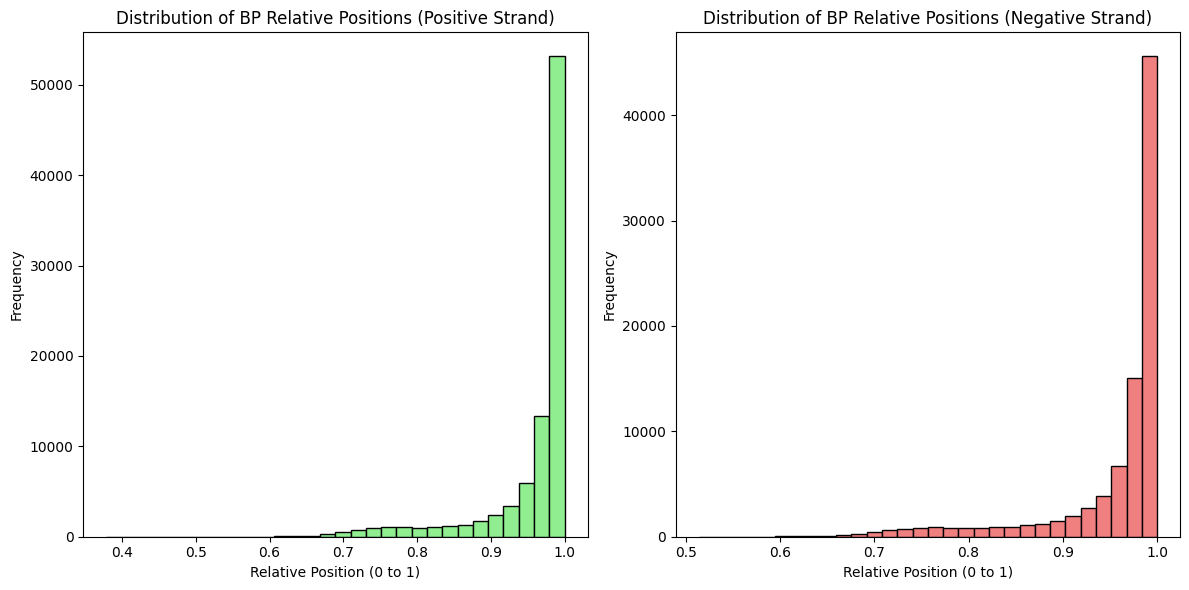

In [20]:
# Create a new column for the relative branch point position
df['BP_RELATIVE_POSITION'] = df['BP_POS_WITHIN_STRAND'] / df['IVS_SIZE']

# Filter the DataFrame for positive and zero strands
positive_strands = df[df['STRAND'] == 1]
negative_strands = df[df['STRAND'] == 0]

# Plot for positive strands
plt.figure(figsize=(12, 6))

# Histogram for positive strands
plt.subplot(1, 2, 1)
plt.hist(positive_strands['BP_RELATIVE_POSITION'], bins=30, edgecolor='k', color='lightgreen')
plt.title('Distribution of BP Relative Positions (Positive Strand)')
plt.xlabel('Relative Position (0 to 1)')
plt.ylabel('Frequency')

# Histogram for negative strands
plt.subplot(1, 2, 2)
plt.hist(negative_strands['BP_RELATIVE_POSITION'], bins=30, edgecolor='k', color='lightcoral')
plt.title('Distribution of BP Relative Positions (Negative Strand)')
plt.xlabel('Relative Position (0 to 1)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

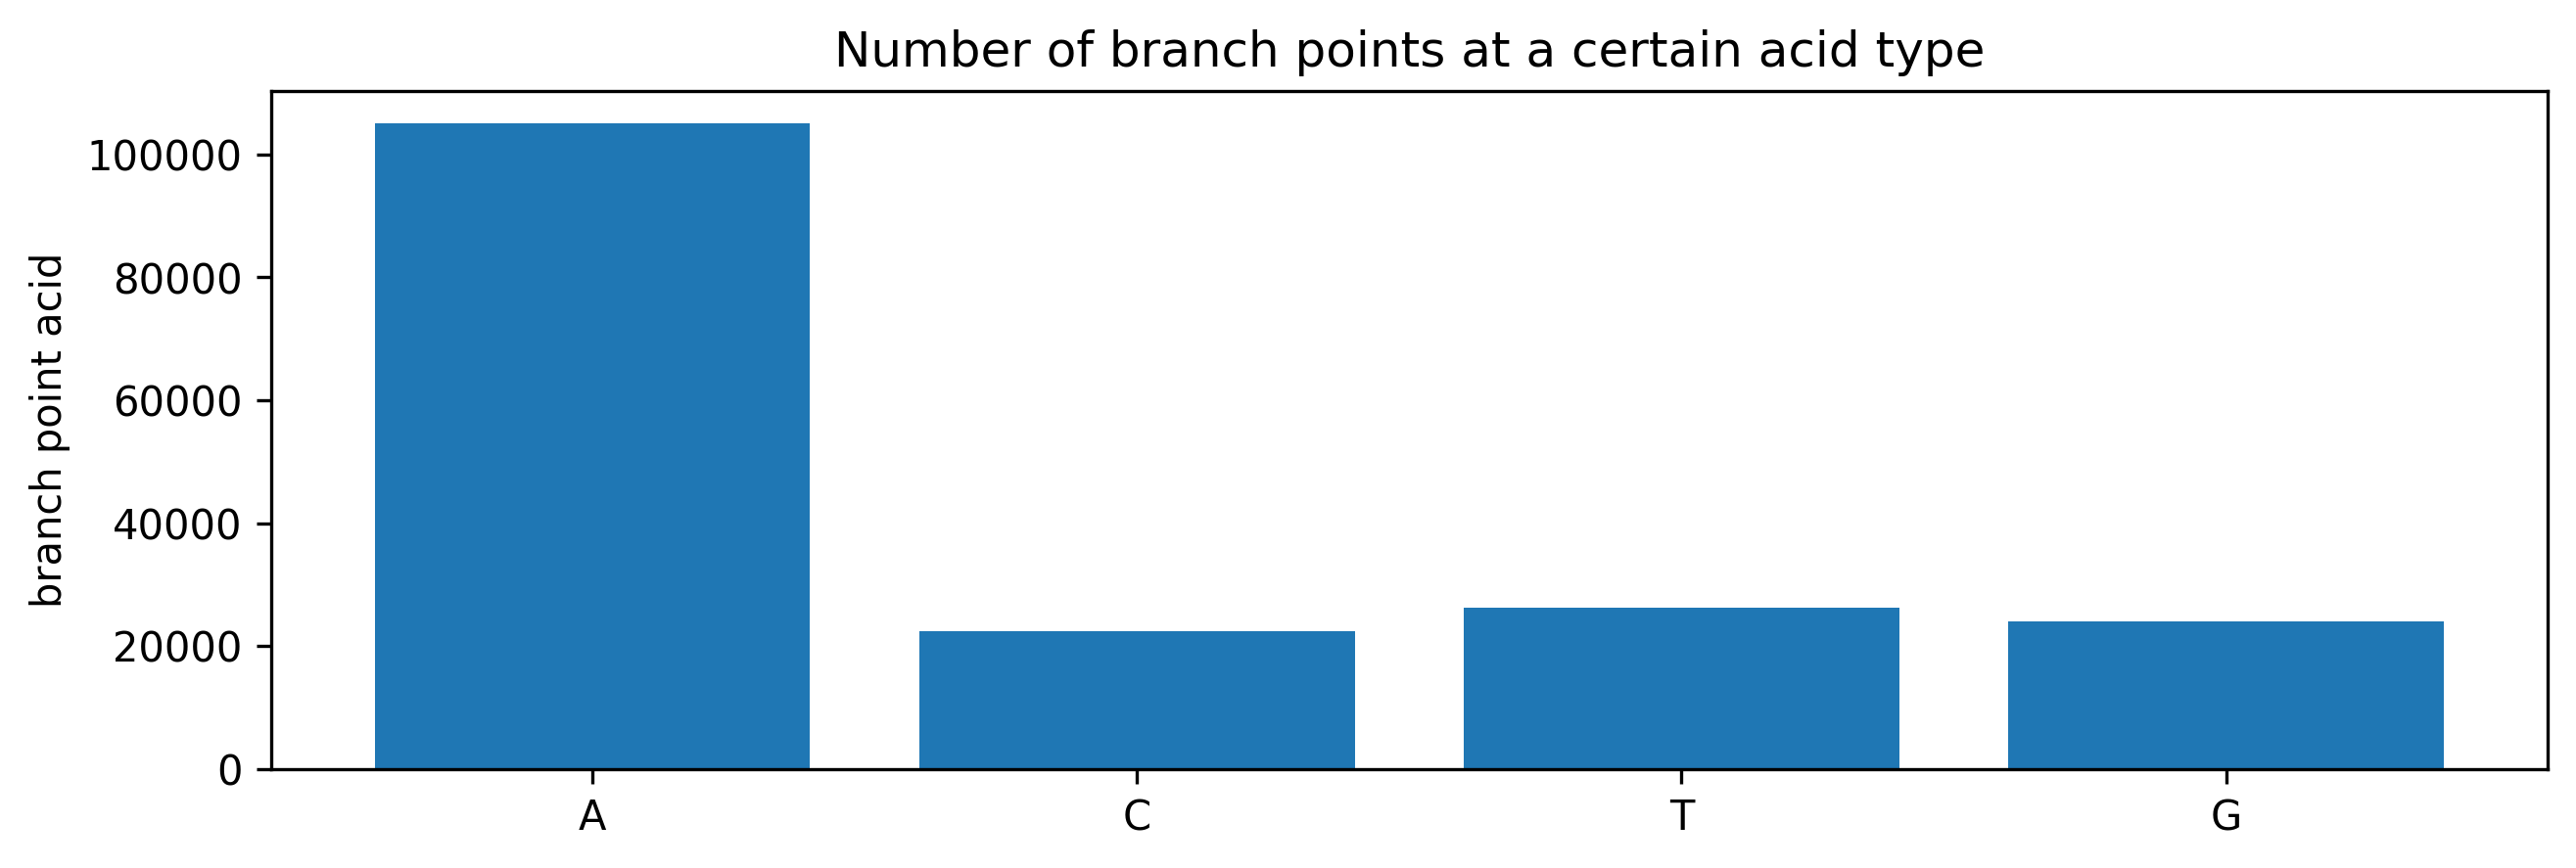

In [28]:
base_counts = {"A": 0, "C": 0, "T": 0, "G": 0}

for i, sequence in enumerate(df["IVS_SEQ"]):
    base = sequence[df["BP_POS_WITHIN_STRAND"][i]]
    if base in base_counts:
        base_counts[base] += 1

As, Cs, Ts, Gs = base_counts["A"], base_counts["C"], base_counts["T"], base_counts["G"]

#Plot abundance of genes
fig, ax = plt.subplots(figsize = (10,3), dpi = 300)
ax.bar(["A", "C", "T", "G"], [As, Cs, Ts, Gs])
ax.set_ylabel('branch point acid')
ax.set_title('Number of branch points at a certain acid type')
plt.show()

In [15]:
train_chrs = ['chr15']
val_chrs = ['chr13']
test_chrs = ['chr18']

train_df, val_df, test_df = split_train_test_on_chr(df, train_chrs, val_chrs, test_chrs)

Chromosomes in train set: {'chr15'}
Chromosomes in validation set: {'chr13'}
Chromosomes in test set: {'chr18'}

Total data points: 12389
Train set contains 6485 data points (52.34%)
Validation set contains 3158 data points (25.49%)
Test set contains 2746 data points (22.16%)


In [16]:
# Extract intron sequences and labels from each set
# and truncate introns longer than max model input length
max_model_length = 1000

introns_tr, labels_tr = extract_intron_seq_and_labels(train_df, max_model_length)
introns_val, labels_val = extract_intron_seq_and_labels(val_df, max_model_length)
introns_test, labels_test = extract_intron_seq_and_labels(test_df, max_model_length)

# Padding still has to be done, but that can be done automatically
# NOTE: Makes sure to pad ON THE LEFT

In [17]:
print([len(intron) for intron in introns_tr])
print([len(label) for label in labels_tr])
print(introns_tr[3])
print(labels_tr[3])

[396, 1000, 1000, 1000, 1000, 1000, 95, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 181, 229, 1000, 1000, 119, 1000, 1000, 1000, 453, 1000, 449, 1000, 1000, 1000, 509, 1000, 1000, 388, 114, 607, 167, 596, 1000, 231, 1000, 1000, 1000, 1000, 941, 1000, 355, 206, 1000, 1000, 1000, 1000, 212, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 692, 1000, 1000, 882, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 601, 1000, 1000, 82, 1000, 1000, 1000, 1000, 1000, 1000, 180, 1000, 1000, 784, 1000, 836, 1000, 263, 1000, 1000, 1000, 1000, 1000, 509, 1000, 1000, 1000, 1000, 1000, 1000, 308, 1000, 1000, 1000, 517, 1000, 425, 417, 1000, 1000, 883, 1000, 1000, 519, 1000, 1000, 1000, 1000, 253, 1000, 1000, 289, 1000, 630, 144, 207, 110, 106, 1000, 854, 1000, 575, 1000, 1000, 1000, 1000, 1000, 1000, 149, 1000, 1000, 1000, 1000, 1000, 585, 107, 1000, 1000, 95, 155, 959, 1000, 114, 1000, 1000, 1000, 696, 824, 1000, 1000, 114, 195, 1000, 1000, 96, 1000, 1000, 1000, 1000, 876, 1000, 499, 741, 1000

In [ ]:
# Some very basic finetuning using the HyenaDNA small model and just the IVS_SEQ and BP as the data

# Instantiate pretrained model
checkpoint = "LongSafari/hyenadna-medium-160k-seqlen-hf"
max_length = 32_000

# bfloat16 for better speed and reduced memory usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=2, torch_dtype=torch.bfloat16, device_map="auto")



sequences = ["AUGCUA", "GCUAAUUGC", "AUCG"]
labels = [
    [0, 0, 1, 0, 0, 0],  # BP at index 2
    [0, 0, 0, 0, 1, 0, 0, 0, 0],  # BP at index 5
    [0, 1, 0, 0]  # BP at index 1
]

# Tokenize the sequences
tokenized_inputs = tokenizer(sequences, padding=True, truncation=True, max_length=max_length, return_tensors='pt', is_split_into_words=True)


# Create a dataset for training
dataset_dict = {
    "input_ids": tokenized_inputs["input_ids"],
    "labels": labels,
}
ds = Dataset.from_dict(dataset_dict)
ds.set_format("torch")

# Initialize Trainer
args = {
    "output_dir": "tmp",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "gradient_checkpointing": True,
    "learning_rate": 2e-5,
}
training_args = TrainingArguments(**args)

trainer = Trainer(model=model, args=training_args, train_dataset=ds)

# Train the model
result = trainer.train()

print(result)